In [86]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import ensemble
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [32]:
train = pd.read_csv("C:/Users/bodak/Desktop/data/train1.csv")
test = pd.read_csv("C:/Users/bodak/Desktop/data/test1.csv")

train = train.drop(columns=["Id"])

y = train["SalePrice"]
X = train.drop(columns=["SalePrice"])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [34]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

In [35]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [36]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\bodak\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5769644156.36145, tolerance: 663740509.6745821
  max_iter, tol, rng, random, positive)


In [37]:
math.sqrt(mean_squared_error(y_test, y_pred))

26468.40147166308

In [38]:
#Creating new features

X_train['TotalArea'] = X_train['TotalBsmtSF'] + X_train['1stFlrSF'] + X_train['2ndFlrSF'] + X_train['GrLivArea'] + X_train['GarageArea']
X_train['YearAvrg'] = (X_train['YearBuilt'] + X_train['YearRemodAdd'])/2
X_train['TotalBsmtFin'] = X_train['BsmtFinSF1'] + X_train['BsmtFinSF2']
X_train['TotalBath'] = X_train['FullBath'] + X_train['HalfBath'] + X_train['BsmtFullBath'] + X_train['BsmtHalfBath']

#Creating new features

X_test['TotalArea'] = X_test['TotalBsmtSF'] + X_test['1stFlrSF'] + X_test['2ndFlrSF'] + X_test['GrLivArea'] + X_test['GarageArea']
X_test['YearAvrg'] = (X_test['YearBuilt'] + X_test['YearRemodAdd'])/2
X_test['TotalBsmtFin'] = X_test['BsmtFinSF1'] + X_test['BsmtFinSF2']
X_test['TotalBath'] = X_test['FullBath'] + X_test['HalfBath'] + X_test['BsmtFullBath'] + X_test['BsmtHalfBath']


In [54]:
numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha=263))
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [55]:
math.sqrt(mean_squared_error(y_test, y_pred))

25608.407715283094

In [57]:
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 221


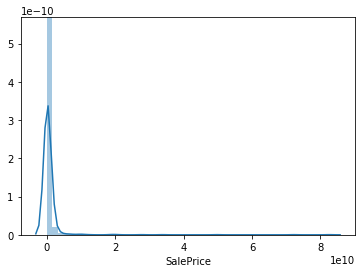

In [58]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)

In [81]:
mask = (error < np.quantile(error, 0.95))

In [82]:
model = lasso_pipeline.fit(X_train[mask], y_train[mask])

In [83]:
y_pred = model.predict(X_test)
math.sqrt(mean_squared_error(y_test, y_pred))

24900.279653948422

In [89]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

xgb_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', XGBRegressor())
])

In [103]:
xgb_model = xgb_pipeline.fit(X_train,y_train)
y_pred_xgb = xgb_model.predict(X_test)
math.sqrt(mean_squared_error(y_test, y_pred_xgb))

25728.193297024998

In [128]:
parameters = {
    'regression__max_depth': range (3, 5, 1),
    'regression__n_estimators': range(300, 1500, 150),
    'regression__learning_rate': [0.1, 0.01, 0.05]
}

In [129]:
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [130]:
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 17.0min
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed: 19.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ohe_and_scaling',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='ignore',
                                  

In [139]:
grid_search.best_params_ 

{'regression__learning_rate': 0.1,
 'regression__max_depth': 3,
 'regression__n_estimators': 450}

In [141]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

xgb_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', XGBRegressor(learning_rate = 0.1,max_depth = 3,n_estimators = 450))
])

In [142]:
xgb_model = xgb_pipeline.fit(X_train,y_train)

In [143]:
y_pred_xgb = xgb_model.predict(X_test)
math.sqrt(mean_squared_error(y_test, y_pred_xgb))

23280.423059446606

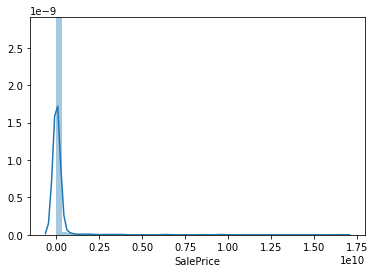

In [158]:
error_xgb = (y_train - xgb_model.predict(X_train)) ** 2
sns.distplot(error_xgb)

In [159]:
mask_xgb = (error_xgb < np.quantile(error_xgb, 0.95))
model_minus_err = xgb_pipeline.fit(X_train[mask_xgb], y_train[mask_xgb])

In [160]:
y_pred_xgb_minus_err = model_minus_err.predict(X_test)
math.sqrt(mean_squared_error(y_test, y_pred_xgb_minus_err))

22965.90241122421

In [170]:
test = pd.read_csv("C:/Users/bodak/Desktop/data/test1.csv")
test_id = test['Id']
test = test.drop(columns=["Id"])

In [171]:
test = test.fillna(numeric_data_mean)
test[categorical] = test[categorical].fillna("NotGiven")

In [172]:
test['TotalArea'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF'] + test['GrLivArea'] + test['GarageArea']
test['YearAvrg'] = (test['YearBuilt'] + test['YearRemodAdd'])/2
test['TotalBsmtFin'] = test['BsmtFinSF1'] + test['BsmtFinSF2']
test['TotalBath'] = test['FullBath'] + test['HalfBath'] + test['BsmtFullBath'] + test['BsmtHalfBath']

In [173]:
y_subm = model_minus_err.predict(test)

In [174]:
submission = pd.DataFrame({
        "Id": test_id,
        "SalePrice": y_subm })
submission.to_csv('C:/Users/bodak/Desktop/my_submission.csv', index = False)

In [175]:
y_subm = model.predict(test)

In [176]:
submission = pd.DataFrame({
        "Id": test_id,
        "SalePrice": y_subm })
submission.to_csv('C:/Users/bodak/Desktop/my_submission.csv', index = False)